# Rapport d'étude de Segment Anything + Stable Diffusion - Tom LE BER (22308482) & Tony PEROTTINO (22303877)

## I. Installation des bibliothèques

In [1]:
import os
import sys

### 1. Télécharger NLF

#### A. Cloner le repo NLF (`https://github.com/isarandi/nlf.git`)

In [2]:
NLF_DIR = "/content/nlf_repo"

# Cloner le repository (officiel) de NLF dans /content :
if not os.path.exists(NLF_DIR):
    !git clone https://github.com/isarandi/nlf.git "{NLF_DIR}"

Cloning into '/content/nlf_repo'...
remote: Enumerating objects: 304, done.
remote: Counting objects: 100% (304/304), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 304 (delta 139), reused 237 (delta 82), pack-reused 0 (from 0)
Receiving objects: 100% (304/304), 406.85 KiB | 9.92 MiB/s, done.
Resolving deltas: 100% (139/139), done.


#### B. Téléchargement du `TorchScript` associé

In [3]:
%cd {NLF_DIR}

# Créer le dossier pour le modèle et télécharger le TorchScript :
!mkdir -p models
!wget -q -O models/nlf_l_multi.torchscript https://bit.ly/nlf_l_pt # Le lien pointe vers le modèle TorchScript NLF-L publié dans les releases du repo.

# On retourne dans "/content" à la fin de cette cellule (pour éviter des problèmes de chemins dans les prochaines cellules) :
%cd /content

/content/nlf_repo
/content


### 2. Télécharger `Segment Anything (V2)`

In [4]:
SAM2_DIR = "/content/sam2_repo"

# Cloner le repository (officiel) de SAM2 dans /content :
if not os.path.exists(SAM2_DIR):
  !rm -rf "{SAM2_DIR}" 2>/dev/null
  !git clone https://github.com/facebookresearch/sam2.git "{SAM2_DIR}"

  !{sys.executable} -m pip uninstall -y -q SAM-2 sam-2 sam2 2>/dev/null
  !{sys.executable} -m pip install -q -e "{SAM2_DIR}" --config-settings editable_mode=compat

Cloning into '/content/sam2_repo'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 30.84 MiB/s, done.
Resolving deltas: 100% (380/380), done.
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 9.2 MB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


### 3. Télécharger `Stable Diffusion`

...

In [5]:
...

Ellipsis

### 4. Vérification de l'environnement

On importe `torch` et `torchvision` afin de vérifier s'il n'y a pas de conflits de versions à cause de `NLF`, `SAM 2` et `SD`.

In [6]:
import torch
import torchvision

print(f"torch = {torch.__version__}")
print(f"torchvision = {torchvision.__version__}")
print(f"cuda = {torch.cuda.is_available()}")
print(f"torch cuda = {torch.version.cuda}")

torch = 2.9.0+cu126
torchvision = 0.24.0+cu126
cuda = True
torch cuda = 12.6


## II. Chargement des données et import des bibliothèques

### 1. Montage du GitHub et extraction des images

#### A. Montage du GitHub

In [7]:
GIT_PATH = "/content/stage_midl_2"

# S'il n'a pas déjà été importé, clonage du dépôt GitHub :
if not os.path.exists(GIT_PATH):
    !git clone https://github.com/tominien/stage_midl_2.git "{GIT_PATH}"

# Si le dépôt a déjà été importé, on le réinitialise et le met à jour :
else:
    !git -C "{GIT_PATH}" fetch --all
    !git -C "{GIT_PATH}" reset --hard origin/main
    !git -C "{GIT_PATH}" pull

Cloning into '/content/stage_midl_2'...
remote: Enumerating objects: 1369, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1369 (delta 5), reused 9 (delta 2), pack-reused 1354 (from 1)
Receiving objects: 100% (1369/1369), 3.32 GiB | 38.75 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (1334/1334), done.


#### B. Définition des chemins

In [8]:
BASE_DIRECTORY = f"{GIT_PATH}/data"
VIDEO_PATH = f"{BASE_DIRECTORY}/video.mp4"
FRAMES_DIRECTORY = f"{BASE_DIRECTORY}/frames"
RESULTS_DIRECTORY = f"/content/results"

# Créer le dossier "frames", s'il n'existe pas déjà :
os.makedirs(FRAMES_DIRECTORY, exist_ok=True)

#### C. Extraction toutes les images de la vidéo

In [9]:
# Extraire toutes les frames de la vidéo si le dossier (des frames) est vide :
if not (os.path.isdir(FRAMES_DIRECTORY) and os.listdir(FRAMES_DIRECTORY)):
    !ffmpeg -i "{VIDEO_PATH}" "{FRAMES_DIRECTORY}/frame_%04d.png" -hide_banner -loglevel error

### 2. Import de `NLF`

Dans cette partie, nous appliquons le modèle NLF à la vidéo de pole-dance.  
L’objectif est de :
1. Charger le modèle NLF (version TorchScript) sur GPU.
2. Définir une fonction d’inférence sur une image unique (frame).
3. Appliquer NLF à un sous-ensemble de frames de la vidéo.
4. Visualiser et analyser qualitativement les prédictions (joints 2D et 3D).

Ensuite, chargeons la version TorchScript du modèle NLF (`nlf_l_multi.torchscript`), qui a été téléchargée dans le dossier `/content/nlf/models/` depuis les Releases du dépôt GitHub.

#### A. Initialisation des paramètres

In [10]:
import glob
import numpy as np

# Paramètres d'expérience pour NLF :
MAX_FRAMES = 5000 # Nombre maximum de frames à traiter (pour l'étude).
FRAME_STEP = 150 # 1 = toutes les frames, 2 = une frame sur deux, etc.

# FRAMES_DIRECTORY et BASE_DIRECTORY sont supposés définis dans la partie précédente :
frame_paths_all = sorted(glob.glob(os.path.join(FRAMES_DIRECTORY, "frame_*.png")))

# Sous-échantillonnage éventuel (step et nombre de frames maximum) :
frame_paths = frame_paths_all[::FRAME_STEP]
frame_paths = frame_paths[:MAX_FRAMES]

print(f"Nombre total de frames extraites : {len(frame_paths_all)}")
print(f"Nombre de frames utilisées pour NLF : {len(frame_paths)}")

Nombre total de frames extraites : 1329
Nombre de frames utilisées pour NLF : 9


#### B. Chargement du modèle

In [11]:
from tqdm.auto import tqdm

%cd {NLF_DIR}

# Sélection du "device" :
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device utilisé :", device)

# Chemin vers le modèle TorchScript (doit déjà avoir été téléchargé) :
MODEL_PATH = "models/nlf_l_multi.torchscript"

# Chargement du modèle :
model = torch.jit.load(MODEL_PATH, map_location=device).eval()
print("Modèle NLF chargé avec succès.")

# On retourne dans "/content" à la fin de cette cellule (pour éviter des problèmes de chemins dans les prochaines cellules) :
%cd /content

/content/nlf_repo
Device utilisé : cuda
Modèle NLF chargé avec succès.
/content


### 3. Setup de `Segment Anything (V2)`

#### A. Importation de `SAM 2`

In [12]:
# Ajout de SAM2 comme "bibliothèque lisible" pour Python :
if SAM2_DIR not in sys.path:
    sys.path.insert(0, SAM2_DIR)
sys.modules.pop("sam2", None)

# Test des imports :
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.sam2_video_predictor import SAM2VideoPredictor
print(f"Imports de SAM 2 fonctionnels.") # Si on n'a pas le print, c'est qu'on a eu une erreur avant.

Imports de SAM 2 fonctionnels.


#### B. Téléchargement des poids du modèle `SAM 2.1` (`Base Plus`)

In [13]:
CKPT_DIR = f"{SAM2_DIR}/checkpoints"
URL = "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_base_plus.pt"

!mkdir -p "{CKPT_DIR}"
!wget -q --show-progress -nc -P "{CKPT_DIR}/" "{URL}"

sam2.1_hiera_base_p 100%[===================>] 308.62M   330MB/s    in 0.9s    


### 4. Import de `Stable Diffusion`

...

In [14]:
...

Ellipsis

## III. Exécution de `NLF`

### 1. Détection d'une personne dans une frame donnée

Nous définissons une fonction `run_nlf_on_image(img_path)` qui :
1. Charge une image de frame depuis son chemin.
2. La met au bon format pour NLF (batch de taille 1).
3. Appelle `model.detect_smpl_batched(...)`.
4. Récupère les joints 2D et 3D pour **la première personne** détectée.
5. Retourne un dictionnaire Python sérialisable (listes plutôt que tenseurs).

Nous considérons qu’il n’y a qu’une seule personne (la pole-danseuse) dans la scène.

In [15]:
def run_nlf_on_image(img_path: str):
    """
    Applique NLF à une image unique.
    Retourne un dictionnaire contenant :
      - frame : nom de fichier de la frame,
      - has_person : booléen indiquant si une personne a été détectée,
      - joints2d : liste [J, 2] des coordonnées 2D des joints (en pixels),
      - joints3d : liste [J, 3] des coordonnées 3D des joints (repère caméra).
    """
    # Charger l'image (C,H,W), uint8 :
    image = torchvision.io.read_image(img_path).to(device)

    # Ajouter la dimension batch : [1, C, H, W]
    frame_batch = image.unsqueeze(0)

    # Inférence NLF :
    with torch.inference_mode():
        pred = model.detect_smpl_batched(frame_batch)

    # pred["joints2d"] et pred["joints3d"] sont des listes (une entrée par élément du batch) :
    joints2d_batch = pred["joints2d"][0]
    joints3d_batch = pred["joints3d"][0]

    # Si le modèle renvoie [num_persons, J, 2] ou [num_persons, J, 3] :
    if joints2d_batch.ndim == 3:
        # Si aucune personne détectée :
        if joints2d_batch.shape[0] == 0:
            return {
                "frame": os.path.basename(img_path),
                "has_person": False,
                "joints2d": None,
                "joints3d": None,
            }
        # On prend la première personne :
        j2d = joints2d_batch[0] # [J, 2]
        j3d = joints3d_batch[0] # [J, 3]
    else:
        # Cas où le modèle renvoie directement [J, 2] / [J, 3] :
        j2d = joints2d_batch
        j3d = joints3d_batch

    # Conversion en numpy, puis en listes Python :
    j2d_np = j2d.detach().cpu().numpy()
    j3d_np = j3d.detach().cpu().numpy()

    result = {
        "frame": os.path.basename(img_path),
        "has_person": True,
        "joints2d": j2d_np.tolist(), # [J, 2]
        "joints3d": j3d_np.tolist(), # [J, 3]
    }
    return result

### 2. Inférence sur un lot de frames

Nous appliquons maintenant `run_nlf_on_image` à un sous-ensemble de frames :
- Les chemins de frames sont définis dans la cellule de paramètres (`frame_paths`).
- Nous mesurons le **temps d'inférence** par frame.
- Nous stockons les résultats dans une liste `results`, chaque entrée correspondant à une frame.

À la fin, nous sauvegardons les résultats dans un fichier JSON situé dans `BASE_DIRECTORY`.

In [16]:
import time
import json
import glob

results = []
times = []

print(f"Lancement de NLF sur {len(frame_paths)} frames.")

for img_path in tqdm(frame_paths, desc="NLF inference"):
    t0 = time.perf_counter()
    res = run_nlf_on_image(img_path)
    t1 = time.perf_counter()

    res["infer_time"] = t1 - t0 # Temps pour cette frame.
    results.append(res)
    times.append(t1 - t0)

times = np.array(times)

print(f"Nombre total de résultats : {len(results)}")
print(f"Temps moyen par frame : {times.mean()*1000:.1f} ms")
print(f"FPS approximatif : {1.0 / times.mean():.2f}")

# Sauvegarde des résultats dans un JSON :
output_path = os.path.join(RESULTS_DIRECTORY, "nlf_results_subset.json")
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Résultats sauvegardés dans : {output_path}")

Lancement de NLF sur 9 frames.


NLF inference:   0%|          | 0/9 [00:00<?, ?it/s]

Nombre total de résultats : 9
Temps moyen par frame : 3257.8 ms
FPS approximatif : 0.31
Résultats sauvegardés dans : /content/stage_midl_2/data/nlf_results_subset.json


### 3. Visualisation qualitative de NLF

Nous proposons plusieurs visualisations :
1. **Overlay 2D des joints sur une frame** (qualité instantanée de la pose).
2. **Mosaïque de plusieurs frames** avec leurs joints 2D.
3. **Évolution temporelle de la profondeur (Z) d’un joint donné**.
4. **Visualisation 3D d’une pose** à partir de `joints3d`.

Ces visualisations serviront de base à l’analyse qualitative de NLF dans la section suivante.

In [17]:
import matplotlib.pyplot as plt

# Filtrer uniquement les frames où une personne a été détectée :
valid_results = [r for r in results if r["has_person"]]

print(f"Frames avec personne détectée : {len(valid_results)}")

if len(valid_results) == 0:
    raise ValueError("Aucune personne détectée dans les frames sélectionnées.")

Frames avec personne détectée : 9


#### A. Overlay 2D sur une frame

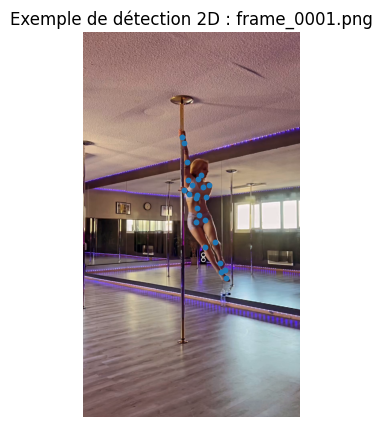

In [18]:
# On prend un exemple (la première) :
sample = valid_results[0]
frame_name = sample["frame"]
j2d = np.array(sample["joints2d"]) # [J, 2]

img_path = os.path.join(FRAMES_DIRECTORY, frame_name)
img = torchvision.io.read_image(img_path).permute(1, 2, 0).cpu().numpy() # [H,W,C]

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.scatter(j2d[:, 0], j2d[:, 1], s=10)
plt.title(f"Exemple de détection 2D : {frame_name}")
plt.axis("off")
plt.show()

#### B. Mosaïque de plusieurs frames avec joints 2D

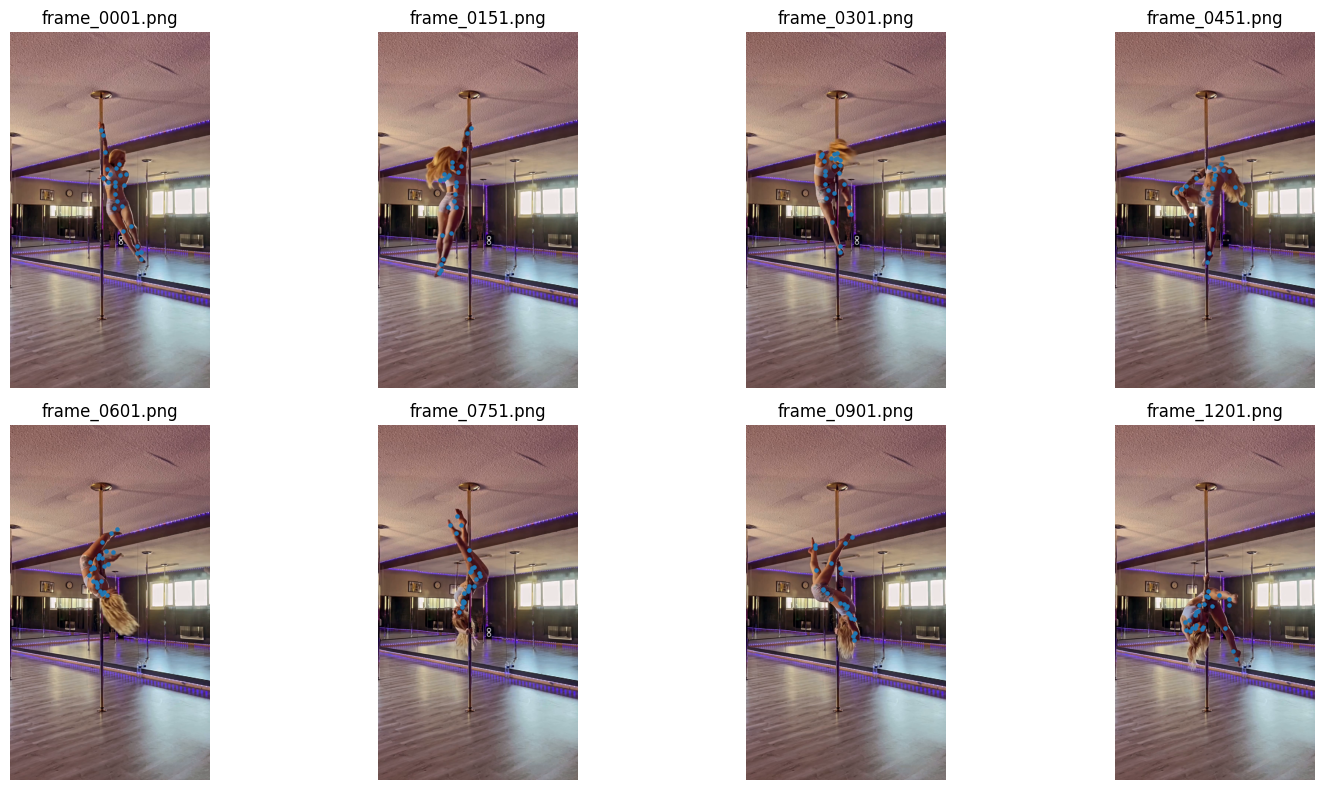

In [19]:
# Nombre d'exemples à afficher dans la mosaïque :
num_examples = min(8, len(valid_results))

# On prend des indices uniformément répartis dans la séquence des frames :
indices = np.linspace(0, len(valid_results) - 1, num_examples, dtype=int)

cols = 4
rows = int(np.ceil(num_examples / cols))

plt.figure(figsize=(4 * cols, 4 * rows))

for i, idx in enumerate(indices, start=1):
    res = valid_results[idx]
    frame_name = res["frame"]
    j2d = np.array(res["joints2d"])

    img_path = os.path.join(FRAMES_DIRECTORY, frame_name)
    img = torchvision.io.read_image(img_path).permute(1, 2, 0).cpu().numpy()

    ax = plt.subplot(rows, cols, i)
    ax.imshow(img)
    ax.scatter(j2d[:, 0], j2d[:, 1], s=5)
    ax.set_title(frame_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### C. Évolution de la profondeur Z d’un joint

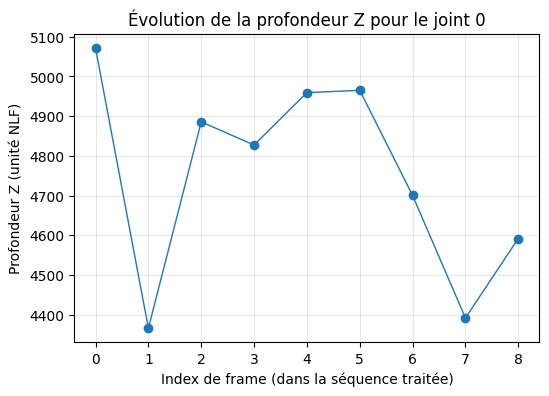

In [20]:
# Indice du joint étudié :
JOINT_INDEX = 0 # 0 = tête.

z_vals = []
frames_idx = []

for i, res in enumerate(results):
    if not res["has_person"]:
        continue
    j3d = np.array(res["joints3d"]) # [J, 3]
    if j3d.shape[0] <= JOINT_INDEX:
        continue
    z_vals.append(j3d[JOINT_INDEX, 2])
    frames_idx.append(i)

plt.figure(figsize=(6, 4))
plt.plot(frames_idx, z_vals, marker="o", linestyle="-", linewidth=1)
plt.xlabel("Index de frame (dans la séquence traitée)")
plt.ylabel("Profondeur Z (unité NLF)")
plt.title(f"Évolution de la profondeur Z pour le joint {JOINT_INDEX}")
plt.grid(True, alpha=0.3)
plt.show()

#### D. Visualisation 3D d’une pose

Frames avec personne détectée : 9


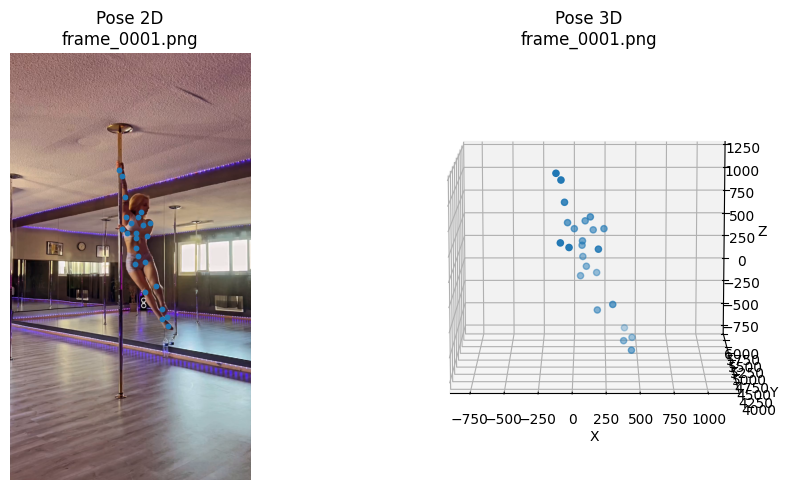

In [21]:
from mpl_toolkits.mplot3d import Axes3D  # Affichage 3D.

# On vérifie qu'on a bien des résultats valides :
valid_results = [r for r in results if r["has_person"]]
print(f"Frames avec personne détectée : {len(valid_results)}")

if len(valid_results) == 0:
    raise ValueError("Aucune personne détectée dans les frames sélectionnées.")

# Choix de l'index de frame à visualiser :
FRAME_INDEX_FOR_3D_VIEW = 0

sample = valid_results[FRAME_INDEX_FOR_3D_VIEW]
frame_name = sample["frame"]
j2d = np.array(sample["joints2d"]) # [J, 2]
j3d = np.array(sample["joints3d"]) # [J, 3]

# Chargement de l'image correspondante :
img_path = os.path.join(FRAMES_DIRECTORY, frame_name)
img = torchvision.io.read_image(img_path).permute(1, 2, 0).cpu().numpy() # [H,W,C]

# Remapping des axes pour que la pose 3D "colle" mieux à l'image :
    # X_vis : gauche/droite
    # Y_vis : profondeur (distance caméra)
    # Z_vis : hauteur (haut/bas) -> on prend -Y pour que le haut soit "vers le haut"
X_vis = j3d[:, 0]
Y_vis = j3d[:, 2]
Z_vis = -j3d[:, 1]

# Petite fonction pour avoir des axes isotropes (squelette non écrasé) :
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range]) / 2.0

    mid_x = np.mean(x_limits)
    mid_y = np.mean(y_limits)
    mid_z = np.mean(z_limits)

    ax.set_xlim3d([mid_x - max_range, mid_x + max_range])
    ax.set_ylim3d([mid_y - max_range, mid_y + max_range])
    ax.set_zlim3d([mid_z - max_range, mid_z + max_range])

# Affichage des figures combinées en 2 colonnes :
fig = plt.figure(figsize=(10, 5))
    # Figure 1 (image + joints 2D) :
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(img)
ax1.scatter(j2d[:, 0], j2d[:, 1], s=10)
ax1.set_title(f"Pose 2D\n{frame_name}")
ax1.axis("off")
    # Figure 2 (visualisation 3D) :
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.scatter(X_vis, Y_vis, Z_vis)
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title(f"Pose 3D\n{frame_name}")
ax2.view_init(elev=10, azim=-90) # Vue "de face" pour que ça ressemble à la projection de l'image.
ax2.grid(True, alpha=0.3) # Grille moins prononcée.
set_axes_equal(ax2)

plt.tight_layout()
plt.show()

## IV. Exécution de `Segment Anything (V2)`

### 1. Création de calques de la danseuse pour une frame unique

Image de test: /content/stage_midl_2/data/frames/frame_0001.png
BBox depuis NLF: [ 468.37456055  454.69119873  731.77338867 1297.54720459]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


sam2.1_hiera_base_plus.pt:   0%|          | 0.00/324M [00:00<?, ?B/s]

scores: [0.96484375 0.8515625  0.95703125] best: 0.96484375
Cutout écrit: /content/sam2_test_cutout.png


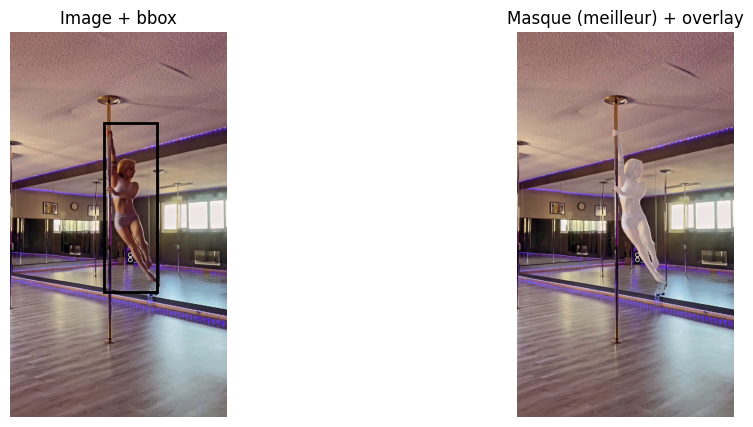

In [22]:
import cv2
import glob

MODEL_ID = "facebook/sam2.1-hiera-base-plus" # Bon compromis vitesse/qualité (checkpoints SAM2.1).

# (1) choisir une image (on prend la première valide) :
if "FRAMES_DIRECTORY" in globals():
    candidates = sorted(glob.glob(os.path.join(FRAMES_DIRECTORY, "*.png")) + glob.glob(os.path.join(FRAMES_DIRECTORY, "*.jpg")))
else:
    candidates = sorted(glob.glob("/content/*.png") + glob.glob("/content/*.jpg"))

test_img_path = candidates[0]
print(f"Image de test:", test_img_path)

bgr = cv2.imread(test_img_path)
assert bgr is not None, "Impossible de lire l'image."
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]

# (2) bbox depuis NLF si possible (sinon fallback) :
bbox = None
if "run_nlf_on_image" in globals():
    try:
        pred = run_nlf_on_image(test_img_path)
        pts = np.array(pred.get("joints2d", []), dtype=float)
        if pts.ndim == 2 and pts.shape[0] > 0 and pts.shape[1] == 2:
            x1, y1 = pts.min(axis=0)
            x2, y2 = pts.max(axis=0)
            pad = 0.10
            bw, bh = (x2 - x1), (y2 - y1)
            bbox = np.array([x1 - pad*bw, y1 - pad*bh, x2 + pad*bw, y2 + pad*bh], dtype=float)
            print("BBox depuis NLF:", bbox)
    except Exception as e:
        print("NLF bbox fallback:", repr(e))

if bbox is None:
    bbox = np.array([0.25*W, 0.10*H, 0.75*W, 0.90*H], dtype=float)
    print("BBox fallback (centrée):", bbox)

bbox[0] = np.clip(bbox[0], 0, W-1)
bbox[2] = np.clip(bbox[2], 0, W-1)
bbox[1] = np.clip(bbox[1], 0, H-1)
bbox[3] = np.clip(bbox[3], 0, H-1)

# (3) SAM2 predictor :
predictor = SAM2ImagePredictor.from_pretrained(MODEL_ID)
device = "cuda" if torch.cuda.is_available() else "cpu"
predictor.model.to(device)

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16, enabled=torch.cuda.is_available()):
    predictor.set_image(img)
    masks, scores, _ = predictor.predict(box=bbox, multimask_output=True)

best_idx = int(np.argmax(scores))
best_mask = masks[best_idx].astype(bool)
print("scores:", scores, "best:", scores[best_idx])

# (4) Export des calques RGBA :
rgba = np.dstack([img, (best_mask.astype(np.uint8) * 255)])
out_path = f"{RESULTS_DIRECTORY}/sam2_test_cutout.png"
cv2.imwrite(out_path, cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA))
print("Cutout écrit:", out_path)

# (5) Visualisation :
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Image + bbox")
plt.imshow(img)
x1,y1,x2,y2 = bbox
plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1, fill=False, linewidth=2))
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Masque (meilleur) + overlay")
overlay = img.copy()
overlay[best_mask] = (0.5*overlay[best_mask] + 0.5*np.array([255,255,255])).astype(np.uint8)
plt.imshow(overlay)
plt.axis("off")
plt.show()

### 2. Obtention des calques sur une série de frames (vidéo)

La stratégie de cette partie repose sur l'utilisation alternée de l'ajout de calques grâces au points donnés par NLF et de la fonction de suivi de calques de SAM V2.

Depuis une série de frames d'entrée, on va définir une longueur de segment de frames fixe.
Chaque segment verra sa première frame analysée par NLF et ensuite confiée à SAM, ce qui nous permettra d'avoir le premier calque de la série étant donné la robustesse de NLF pour détecter les joints d'une personne.

A noter que si la détection échoue sur cette frame précise, l'algorithme cherche automatiquement la personne sur les images suivantes jusqu'à obtenir un ancrage valide.

Ensuite, les autres frames du segment sont traitées par la fonction de propagation de SAM 2, qui utilise la mémoire du premier calque pour prédire et maintenir le détourage sur le reste de la séquence.
Cette approche par blocs permet de réinitialiser régulièrement le tracking, évitant ainsi que le masque ne dérive.
Elle permet aussi de soulager la RAM qui ne peut pas supporter une trop grande analyse simultanée de frames en particulier sur google colab.

#### A. Initialisation et chargement du modèle `SAM 2`

On initialise et on charge le modèle SAM 2 en mémoire à partir des fichiers de configuration et des poids téléchargés.

In [23]:
from sam2.build_sam import build_sam2_video_predictor

%cd {SAM2_DIR}

checkpoint = f"{SAM2_DIR}/checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"

predictor = build_sam2_video_predictor(model_cfg, checkpoint)
print("Predictor SAM2 Video chargé.")

# On retourne dans "/content" à la fin de cette cellule (pour éviter des problèmes de chemins dans les prochaines cellules) :
%cd /content

/content/sam2_repo
Predictor SAM2 Video chargé.
/content


#### B. Obtention des calques pour chaque frame et reconstruction de la vidéo

Le code ci-dessous permet de générer les masques sur la vidéo, conformément à la stratégie plus haut.

In [38]:
import shutil
import cv2
import gc
import numpy as np
from tqdm import tqdm

# Configuration / hyperparamètres :
FRAME_BEGIN = 0
FRAME_END = 1329 # Indice de la dernière frame de la vidéo de la danseuse.
CHUNK_SIZE = 50
TMP_DIR = "/content/sam2_sliding_window"
OUTPUT_CUTOUT_PATH = f"{RESULTS_DIRECTORY}/output_cutout.mp4"
MASK_DIR = "/content/frames_masks"


def find_nlf_anchors(
    files: list[str],
    frames_dir: str = FRAMES_DIRECTORY,
    frame_begin: int = FRAME_BEGIN,
    frame_end: int = FRAME_END,
    chunk_size: int = CHUNK_SIZE
):
    """
    Cherche des "ancres" NLF : pour chaque chunk de frames, prend la 1ère frame où NLF renvoie joints2d non vide.
    """
    anchors = {}
    end_frame = min(frame_end, len(files))

    for start_idx in tqdm(range(frame_begin, end_frame, chunk_size)):
        anchor_found = None

        for current_idx in range(start_idx, min(start_idx + chunk_size, end_frame)):
            img_path = os.path.join(frames_dir, files[current_idx])

            try:
                pred = run_nlf_on_image(img_path)
            except RuntimeError as e:
                print(f"NLF error on frame {current_idx}: {e}")
                continue

            joints = np.asarray(pred.get("joints2d", []), dtype=np.float32)
            if joints.ndim == 0 or joints.size == 0:
                continue
            anchor_found = (current_idx, joints)
            break

        if anchor_found is not None:
            frame_idx, joints = anchor_found
            labels = np.ones(joints.shape[0], dtype=np.int32)
            anchors[frame_idx] = (joints, labels)
        else:
            print(f"WARNING - Aucun point trouvé entre {start_idx} et {min(start_idx + chunk_size - 1, end_frame - 1)}.")

    return anchors


def build_segments_from_anchors(anchors: dict, files: list[str], frame_end: int = FRAME_END):
    """
    Transforme anchors en une liste de segments contigus [start, end), où :
    - start = frame de l’ancre,
    - end = frame de l’ancre suivante, ou end_frame pour le dernier.
    """
    segments = []
    end_frame = min(frame_end, len(files))
    sorted_anchors = sorted(anchors.items(), key=lambda x: x[0])

    for i, (frame_idx, (pts, labels)) in enumerate(sorted_anchors):
        if i + 1 < len(sorted_anchors):
            next_start = sorted_anchors[i + 1][0]
        else:
            next_start = end_frame

        segments.append({
            "start": frame_idx,
            "end": next_start,
            "points": pts,
            "labels": labels
        })

    return segments


def init_video_writer(
    files: list[str],
    frames_dir: str = FRAMES_DIRECTORY,
    output_path: str = OUTPUT_CUTOUT_PATH,
    fps: float = 30.0,
    codec: str = "mp4v"
):
    """
    Initialise VideoWriter à la taille de la première image.
    """
    sample_frame_path = os.path.join(frames_dir, files[0])

    sample_img = cv2.imread(sample_frame_path)
    if sample_img is None:
        raise RuntimeError(f"Impossible de lire l'image: {sample_frame_path}.")

    h, w = sample_img.shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*codec)
    writer = cv2.VideoWriter(output_path, fourcc, fps, (w, h))
    if not writer.isOpened():
        raise RuntimeError(f"VideoWriter impossible à ouvrir: {output_path}.")

    return writer


def process_segments(
    segments: list,
    writer: cv2.VideoWriter,
    files: list[str],
    frames_dir: str = FRAMES_DIRECTORY,
    tmp_dir: str = TMP_DIR,
    output_path: str = OUTPUT_CUTOUT_PATH,
    mask_dir: str = MASK_DIR
):
    # Créer me dossier des masques, s'il n'existe pas déjà :
    if mask_dir is not None:
        os.makedirs(mask_dir, exist_ok=True)

    # Traitement des segments :
    for seg in segments:
        print(f"Segment {seg['start']} --> {seg['end']} en cours...")

        try:
            # Préparer le micro-dossier :
            if os.path.exists(tmp_dir):
                shutil.rmtree(tmp_dir)
            os.makedirs(tmp_dir)

            for i, f_idx in enumerate(range(seg["start"], seg["end"])):
                shutil.copy(
                    os.path.join(frames_dir, files[f_idx]),
                    os.path.join(tmp_dir, f"{i:04d}.jpg")
                )

            # Initialisation SAM 2 :
            inference_state = predictor.init_state(video_path=tmp_dir)
            predictor.reset_state(inference_state)

            predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=0,
                obj_id=1,
                points=seg["points"],
                labels=seg["labels"]
            )

            # Propagation et écriture vidéo :
            with torch.no_grad():
                for out_frame_idx, _, out_mask_logits in predictor.propagate_in_video(inference_state):
                    real_idx = seg["start"] + out_frame_idx
                    mask = (out_mask_logits[0] > 0.0).cpu().numpy().squeeze()

                    # Sauvegarde du masque :
                    if mask_dir is not None:
                        cv2.imwrite(os.path.join(mask_dir, f"{real_idx:05d}.png"), mask * 255)

                    # Génération du cutout (calque sur fond noir) :
                    img = cv2.imread(os.path.join(frames_dir, files[real_idx]))
                    cutout = np.zeros_like(img)
                    cutout[mask] = img[mask]
                    writer.write(cutout)

            print(f"Segment {seg['start']} --> {seg['end']} terminé.")

        except Exception as e:
            print(f"ERREUR - Segment {seg['start']} échoué : {e}")

        finally:
            if "inference_state" in locals():
                del inference_state
            torch.cuda.empty_cache()
            gc.collect()

    # Finalisation :
    writer.release()

    if os.path.exists(tmp_dir):
        shutil.rmtree(tmp_dir)

    print(f"\nVidéo finale générée sous \"{output_path}\".")

#### C. Exécution de `SAM 2`

In [32]:
# (1) Extraction de toutes les frames :
original_files = sorted([f for f in os.listdir(FRAMES_DIRECTORY) if f.lower().endswith(('.png', '.jpg'))])

# (2) Identification des points d'ancrages NLF :
print("Recherche des points d'ancrage NLF...")
anchors = find_nlf_anchors(original_files)

# (3) Construction explicite des segments :
print(f"Construction explicite de {len(anchors)} segments...")
segments = build_segments_from_anchors(anchors, original_files)

# (4) Initialisation du writer vidéo :
writer = init_video_writer(original_files)

# (5) Tracking vidéo SAM 2 sur chaque segment :
print(f"Propagation SAM 2 sur {len(anchors)} segments...")
process_segments(segments, writer, original_files)

Recherche des points d'ancrage NLF...


100%|██████████| 27/27 [00:06<00:00,  4.50it/s]


Construction explicite de 27 segments...
Propagation SAM 2 sur 27 segments...
Segment 0 --> 50 en cours...


frame loading (JPEG): 100%|██████████| 50/50 [00:04<00:00, 10.85it/s]
/content/sam2_repo/sam2/sam2_video_predictor.py:786: UserWarning: /content/sam2_repo/sam2/_C.so: undefined symbol: _ZNK3c1010TensorImpl15incref_pyobjectEv

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 50/50 [00:27<00:00,  1.79it/s]


Segment 0 --> 50 terminé.
Segment 50 --> 100 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


Segment 50 --> 100 terminé.
Segment 100 --> 150 en cours...


propagate in video: 100%|██████████| 50/50 [00:28<00:00,  1.75it/s]


Segment 100 --> 150 terminé.
Segment 150 --> 200 en cours...


propagate in video: 100%|██████████| 50/50 [00:28<00:00,  1.74it/s]


Segment 150 --> 200 terminé.
Segment 200 --> 250 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.72it/s]


Segment 200 --> 250 terminé.
Segment 250 --> 300 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


Segment 250 --> 300 terminé.
Segment 300 --> 350 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 300 --> 350 terminé.
Segment 350 --> 400 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 350 --> 400 terminé.
Segment 400 --> 450 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Segment 400 --> 450 terminé.
Segment 450 --> 500 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Segment 450 --> 500 terminé.
Segment 500 --> 550 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Segment 500 --> 550 terminé.
Segment 550 --> 600 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 550 --> 600 terminé.
Segment 600 --> 650 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 600 --> 650 terminé.
Segment 650 --> 700 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 650 --> 700 terminé.
Segment 700 --> 750 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 700 --> 750 terminé.
Segment 750 --> 800 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 750 --> 800 terminé.
Segment 800 --> 850 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 800 --> 850 terminé.
Segment 850 --> 900 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 850 --> 900 terminé.
Segment 900 --> 950 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 900 --> 950 terminé.
Segment 950 --> 1000 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 950 --> 1000 terminé.
Segment 1000 --> 1050 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 1000 --> 1050 terminé.
Segment 1050 --> 1100 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


Segment 1050 --> 1100 terminé.
Segment 1100 --> 1151 en cours...


propagate in video: 100%|██████████| 51/51 [00:30<00:00,  1.69it/s]


Segment 1100 --> 1151 terminé.
Segment 1151 --> 1200 en cours...


propagate in video: 100%|██████████| 49/49 [00:28<00:00,  1.70it/s]


Segment 1151 --> 1200 terminé.
Segment 1200 --> 1250 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Segment 1200 --> 1250 terminé.
Segment 1250 --> 1300 en cours...


propagate in video: 100%|██████████| 50/50 [00:29<00:00,  1.69it/s]


Segment 1250 --> 1300 terminé.
Segment 1300 --> 1329 en cours...


propagate in video: 100%|██████████| 29/29 [00:16<00:00,  1.76it/s]


Segment 1300 --> 1329 terminé.

Vidéo finale générée sous "/content/output_cutout.mp4".


## V. Exécution de `Stable Diffusion`

On a, pour chaque frame de la vidéo, une image + un masque (SAM 2) qui découpe la danseuse.  
Le nouveau fond n’a pas la même taille et la barre de pole n’est pas au même endroit : si on “colle” directement la danseuse, elle est mal alignée.

L’idée est donc d’utiliser la **barre** comme repère commun :
- On choisit **2 points** sur la barre dans la vidéo (haut / bas).
- On choisit les **2 mêmes points** sur la barre dans le nouveau fond.
- À partir de ces deux segments, on calcule une transformation **rotation + scale + translation** (similarity transform) qui envoie la barre de la vidéo sur la barre du fond.
- Pour chaque frame, on applique cette même transformation au **calque danseuse** (image) et à son **masque alpha**, puis on fait le **compositing** sur le nouveau fond :
  - `out = img_warp * alpha + bg * (1 - alpha)`.

Point important : les masques étant sauvegardés avec un index “liste” (`00000.png`, `00001.png`, ...), on associe correctement **frame i <=> masque i** (et pas via le numéro dans le nom `frame_0001.png`).

In [43]:
import re

NEW_BG_PATH = f"{BASE_DIRECTORY}/new_background.png"
OUTPUT_NEW_BACKGROUNG_PATH = f"{RESULTS_DIRECTORY}/output_with_new_background.mp4"

# Coordonnées de la barre sur la vidéo d'entrée (la barre est fixe) :
SRC_POLE_TOP = (492, 363)
SRC_POLE_BOTTOM = (496, 1544)

# Coordonnées de la barre sur l'image de sortie :
DST_POLE_TOP = (470, 185)
DST_POLE_BOTTOM = (470, 828)


def similarity_affine_from_2pts(src_top: tuple, src_bottom: tuple, dst_top: tuple, dst_bottom: tuple):
    """
    Construit une matrice affine 2x3 (rotation+scale+translation) telle que :
      src_top --> (aille sur) dst_top
      src_bottom --> (aille sur) dst_bottom
    Les points sont en (x, y) pixels.
    """
    src_top = np.array(src_top, dtype=np.float32)
    src_bottom = np.array(src_bottom, dtype=np.float32)
    dst_top = np.array(dst_top, dtype=np.float32)
    dst_bottom = np.array(dst_bottom, dtype=np.float32)

    v_src = src_bottom - src_top
    v_dst = dst_bottom - dst_top

    norm_src = float(np.linalg.norm(v_src))
    norm_dst = float(np.linalg.norm(v_dst))
    if norm_src < 1e-6:
        raise ValueError("src_top et src_bottom sont trop proches (norme ~ 0).")

    # Scale :
    s = norm_dst / norm_src

    # Rotation :
    ang_src = np.arctan2(v_src[1], v_src[0])
    ang_dst = np.arctan2(v_dst[1], v_dst[0])
    theta = float(ang_dst - ang_src)

    c = np.cos(theta)
    sn = np.sin(theta)

    # M = s*R
    M2 = s * np.array([[c, -sn],
                       [sn,  c]], dtype=np.float32)

    # translation : dst_top = M2 @ src_top + t
    t = dst_top - (M2 @ src_top)

    # Matrice 2x3 pour cv2.warpAffine :
    A = np.array([[M2[0,0], M2[0,1], t[0]],
                  [M2[1,0], M2[1,1], t[1]]], dtype=np.float32)
    return A


def render_with_background_aligned_on_pole(
    files,
    src_pole_top = SRC_POLE_TOP,
    src_pole_bottom = SRC_POLE_BOTTOM,
    dst_pole_top = DST_POLE_TOP,
    dst_pole_bottom = DST_POLE_BOTTOM,
    bg_path = NEW_BG_PATH,
    frames_dir = FRAMES_DIRECTORY,
    mask_dir = MASK_DIR,
    output_path = OUTPUT_NEW_BACKGROUNG_PATH,
    fps = 30.0,
    codec = "mp4v",
    feather_sigma = 2.0
):
    bg = cv2.imread(bg_path, cv2.IMREAD_COLOR)
    if bg is None:
        raise FileNotFoundError(f"Fond introuvable: {bg_path}")
    out_h, out_w = bg.shape[:2]

    A = similarity_affine_from_2pts(src_pole_top, src_pole_bottom, dst_pole_top, dst_pole_bottom)

    mask_offset = 0 if os.path.exists(os.path.join(mask_dir, "00000.png")) else 1

    fourcc = cv2.VideoWriter_fourcc(*codec)
    writer = cv2.VideoWriter(output_path, fourcc, fps, (out_w, out_h))
    if not writer.isOpened():
        raise RuntimeError(f"VideoWriter impossible à ouvrir: {output_path}")

    for i, f in enumerate(files):
        frame_path = os.path.join(frames_dir, f)
        img = cv2.imread(frame_path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Frame introuvable: {frame_path}")

        mask_path = os.path.join(mask_dir, f"{i + mask_offset:05d}.png")
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(f"Masque introuvable: {mask_path}")

        alpha = (m.astype(np.float32) / 255.0)

        img_warp = cv2.warpAffine(
            img, A, (out_w, out_h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0)
        )
        alpha_warp = cv2.warpAffine(
            alpha, A, (out_w, out_h),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )

        if feather_sigma and feather_sigma > 0:
            alpha_warp = cv2.GaussianBlur(alpha_warp, (0, 0), feather_sigma)
        alpha_warp = np.clip(alpha_warp, 0.0, 1.0)

        out = img_warp.astype(np.float32) * alpha_warp[..., None] + bg.astype(np.float32) * (1.0 - alpha_warp[..., None])
        out_u8 = out.astype(np.uint8)

        writer.write(out_u8)

    writer.release()
    print(f"Vidéo finale générée sous \"{output_path}\".")

In [44]:
render_with_background_aligned_on_pole(original_files)

[DEBUG] i=0 frame='frame_0001.png' mask='00000.png' mean=133.49
[DEBUG] i=1 frame='frame_0002.png' mask='00001.png' mean=133.41
[DEBUG] i=2 frame='frame_0003.png' mask='00002.png' mean=133.34
[DEBUG] i=3 frame='frame_0004.png' mask='00003.png' mean=133.28
[DEBUG] i=4 frame='frame_0005.png' mask='00004.png' mean=133.25
Vidéo finale générée sous "/content/output_with_new_background.mp4".


## VI. Conclusion

Nous avons encore 2 problèmes :
- Les cheuveux de la danseuses ne sont pas tous les temps inclus dans le découpage, il faudra trouver une logique pour les inclure.
- La méthode de replacement de la danseuse est fonctionnelle mais fastidieuse (calcul à la main des points). De plus, elle ne marche que dans le cadre des vidéos de pole dance.
  - Il faudrait donc trouver une méthode "plus générale et plus automatique" pour correctement replacer la danseuse.